## Train GPT Model on JSON data

In [19]:
# Imports and Setup
import torch
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datasets import Dataset
from tqdm.notebook import tqdm
import psutil
import gc
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Check if MPS is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [20]:
# Load and prepare tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Create custom config
config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=128,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    hidden_size=128, 
    num_attention_heads=4,
    num_hidden_layers=4,
)

model = GPT2LMHeadModel(config).to(device)

In [21]:
from pymongo import MongoClient
import json

# Load dataset
def load_json_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    return Dataset.from_dict({"text": [line.strip() for line in lines]})

def load_from_mongodb(uri, database, collection):
    client = MongoClient(uri)
    db = client[database]
    collection = db[collection]
    docs = list(collection.find(projection={"_id": 0}))
    for doc in docs:
        target = doc["target"]
        del doc["target"]
        doc["target"] = target

    return Dataset.from_dict({"docs": [json.dumps(d) for d in docs], "target": [d["target"] for d in docs]})

dataset = load_from_mongodb("mongodb://localhost:27017/", "openml", "1590-adult")
dataset_split = dataset.train_test_split(test_size=0.2, seed=42, shuffle=True)
train_dataset = dataset_split['train']
test_dataset = dataset_split['test']

print(f"Full dataset size: {len(dataset)} samples")
print(f"Train dataset size: {len(train_dataset)} samples")
print(f"Test dataset size: {len(test_dataset)} samples")

Full dataset size: 48842 samples
Train dataset size: 39073 samples
Test dataset size: 9769 samples


In [22]:
# Cell 6: Tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples["docs"], truncation=True, padding="max_length", max_length=128)

# Use tqdm to show progress
train_tokenized = train_dataset.map(tokenize_function, batched=True, batch_size=1000, 
                                    remove_columns=train_dataset.column_names, 
                                    desc="Tokenizing train dataset")
test_tokenized = test_dataset.map(tokenize_function, batched=True, batch_size=1000, 
                                  remove_columns=test_dataset.column_names, 
                                  desc="Tokenizing test dataset")


Tokenizing train dataset:   0%|          | 0/39073 [00:00<?, ? examples/s]

Tokenizing test dataset:   0%|          | 0/9769 [00:00<?, ? examples/s]

In [7]:
from transformers import TrainerCallback

class LossCallback(TrainerCallback):
    def __init__(self):
        self.training_loss = []
        self.step = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if state.is_local_process_zero and 'loss' in logs:
            self.training_loss.append(logs['loss'])
            self.step.append(state.global_step)
            self.plot_loss()

    def plot_loss(self):
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        plt.plot(self.step, self.training_loss)
        plt.title('Training Loss Curve')
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.show()

    # Implement other required methods as no-ops
    def on_init_end(self, args, state, control, **kwargs):
        pass

    def on_train_begin(self, args, state, control, **kwargs):
        pass

    def on_train_end(self, args, state, control, **kwargs):
        pass

loss_callback = LossCallback()

In [8]:

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none",  # Disable wandb logging
)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    data_collator=data_collator,
    callbacks=[loss_callback]
)


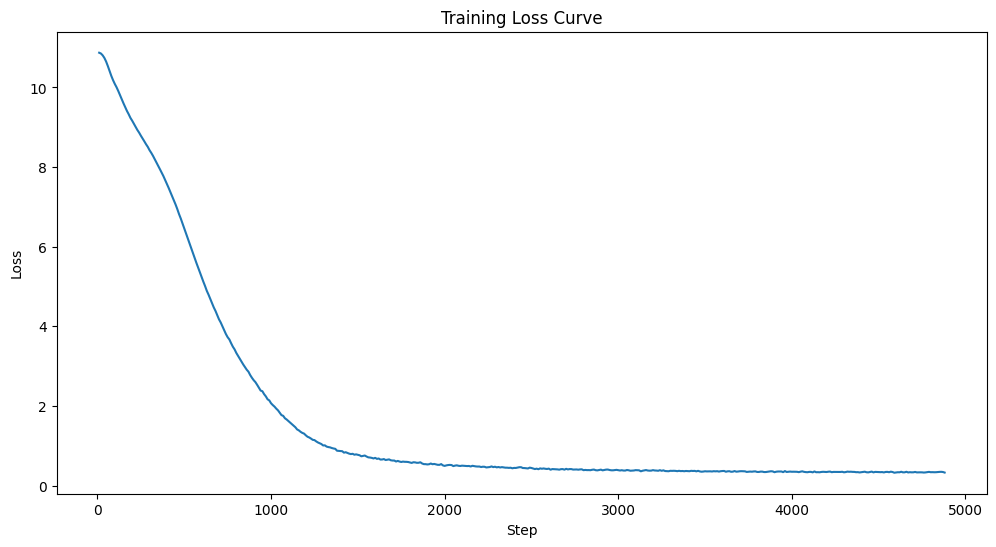

Model saved!


In [9]:

# Train model
print("Starting training...")
trainer.train()
print("Training completed!")

loss_callback.plot_loss()

# Save the model
model.save_pretrained("./results/checkpoint-final")
tokenizer.save_pretrained("./results/checkpoint-final")
print("Model saved!")


In [18]:

# Memory cleanup
del model, trainer, tokenizer, train_tokenized, test_tokenized, dataset, train_dataset, test_dataset, dataset_split
gc.collect()
print(f"Current memory usage: {psutil.virtual_memory().percent}%")

Current memory usage: 79.7%


## Evaluation

In [23]:
model = GPT2LMHeadModel.from_pretrained("./results/checkpoint-final")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [24]:
from transformers import Trainer, TrainingArguments
import numpy as np
import torch

# Set up evaluation arguments
eval_args = TrainingArguments(
    output_dir="./eval_results",
    do_train=False,
    do_eval=True,
    per_device_eval_batch_size=100,
    dataloader_drop_last=False
)

# Create a Trainer instance for evaluation
eval_trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=test_tokenized,
    data_collator=data_collator
)

# Run evaluation
eval_results = eval_trainer.evaluate()

# Print evaluation results
print("Evaluation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value}")

# Calculate perplexity
perplexity = np.exp(eval_results['eval_loss'])
print(f"Perplexity: {perplexity}")

# Generate some text as a sanity check
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
model.eval()


  0%|          | 0/98 [00:00<?, ?it/s]

Evaluation Results:
eval_loss: 0.32202956080436707
eval_model_preparation_time: 0.0004
eval_runtime: 34.7176
eval_samples_per_second: 281.384
eval_steps_per_second: 2.823
Perplexity: 1.3799255670640636


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 128)
    (wpe): Embedding(1024, 128)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-3): 4 x GPT2Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=128, out_features=50257, bias=False)
)

In [25]:

prompt = "{"
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

with torch.no_grad():
    output = model.generate(input_ids, 
                            max_length=50, 
                            num_return_sequences=1, 
                            no_repeat_ngram_size=2,
                            top_k=50,
                            top_p=0.95,
                            temperature=0.7)

generated_text = tokenizer.decode(output[0], skip_special_tokens=False)
print("\nGenerated Text:")
print(generated_text)

/Users/tr/code/python/docformer/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/Users/tr/code/python/docformer/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


ValueError: Can't infer missing attention mask on `mps` device. Please provide an `attention_mask` or use a different device.